# Dendrogram samples

This notebook applies the methods explored in [progress_report_4.ipynb](progress_report_4.ipynb) to an assortment of poems with different properties. It begins by consolidating the run script into a function, which is then called against different samples.

## Reload libraries each time, since we’re tinkering with them

In [1]:
%load_ext autoreload
%autoreload 2

## Load libraries

In [2]:
from xml.dom import pulldom  # parse input XML
from xml.dom.minidom import Document  # construct output XML
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
# see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from cyr2phon import cyr2phon  # custom package
pd.set_option('display.max_colwidth', -1) # show all text in cell, without truncation; default is 50

## Class and variables for parsing input XML

In [3]:
class Stack(list):  # keep track of open nodes while constructing XML output
    def push(self, item):
        self.append(item)

    def peek(self):  
        return self[-1]


open_elements = Stack()
WS_RE = re.compile(r'\s+')  # normalize white space in output

## Function to parse the XML

Returns a list of lists, with stanza number, line number, and `<line>` element for each line. We use the light-weight *xml.dom.pulldom* library to parse the input XML and *xml.dom.minidom* to construct the lines as simplified XML, removing elements we don’t care about, such as `<latin>` and `<italic>`, before serializing them to the output. (We actually do care about `<latin>`, but we are ignoring it temporarily, and we’ll return to it at a later stage in the project.)

In [35]:
def process(input_xml):
    poemId = ""
    stanzaNo = 0
    lineNo = 0
    inline = 0  # flag to control behavior inside and outside lines
    result = []  # array of arrays, one per line, with stanzaNo, lineNo, and serialized XML
    doc = pulldom.parse(input_xml)
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.localName == 'poem':
            poemId = node.getAttribute("opid")
        elif event == pulldom.START_ELEMENT and node.localName == 'stanza':
            stanzaNo = node.getAttribute("stanzaNo")
        elif event == pulldom.START_ELEMENT and node.localName == 'line':
            d = Document()  # each line is an output XML document
            open_elements.push(d)  # document node
            lineNo = node.getAttribute("lineNo")
            inline = 1  # we’re inside a line
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'line':
            inline = 0  # when we finish our work here, we’ll no longer be inside a line
            open_elements.pop()  # line is finished
            # serialize XML, strip declaration, rewrite &quot; entity as character
            result.append([poemId, int(stanzaNo), (lineNo),
                WS_RE.sub(" " ,
                open_elements.pop().toxml().replace('<?xml version="1.0" ?>', '').replace('&quot;', '"'))])
        elif event == pulldom.START_ELEMENT and node.localName == 'stress':
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'stress':
            open_elements.pop()  # stress element is finished
        elif event == pulldom.CHARACTERS and inline:  # keep text only inside lines
            t = d.createTextNode(node.data)
            open_elements.peek().appendChild(t)
    return result

## Function to extract rhyme zone from rhyme word

In [36]:
rhymezonepat = re.compile(r'(.?[AEIOU]$)|([AEIOU][^AEIOU]*$)')
def remove_pretonic_segments(s: str) -> str: # removes segments in place
    try:
        return rhymezonepat.search(s.replace(' ', '')).group(0)
    except: # modify this to raise a real error, instead of just reporting
        print('Error: ', s)

## Imports sample file, analyzes, outputs reports

In [37]:
def explore(filepath, ceiling=1000, ward=None):
    '''Render text and dendrograms of rhyme clustering
    
    Parameters:
        filepath (str): path to XML file with poem, required
        ceiling (int): maximum number of stanzas to return (useful for sampling long poems), 
            defaults to high value
        ward (boolean): show Ward dendrogram separately (improves legibility of long stanzas),
            defaults to None
    
    Does not return a value; all output is written directly from within the function
    '''
    
    # Read file
    with open(filepath) as f:
        data = process(f)
    df = pd.DataFrame(data, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
    
    # Prepare data
    # Prepare data
    trans_vec = np.vectorize(cyr2phon.transliterate)
    df["Phonetic"] = trans_vec(df["Text"])
    df["RhymeZone"] = df["Phonetic"].apply(remove_pretonic_segments)
#     df.loc[df["RhymeZone"].isnull(), "RhymeZone"] = "Abcde" # provisional placeholder for nulls
    df["tokenized"] = [x[0] for x in df["RhymeZone"].str.
                       findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]

    i = 0
    while pd.np.count_nonzero([item[i] for item in df["tokenized"]]) > 0:
        # print([item[i] for item in df["tokenized"]]) # diagnostic
        df["token" + str(i)] = [item[i] for item in df["tokenized"]]
        i += 1
    tokenheaders = df.filter(regex="^token\d").columns
    df[tokenheaders] = df[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
    df.filter(regex=r"StanzaNo|LineNo|Text|^token\d").head() # columns we care about
    dummy = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)
    df = df.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeZone", "tokenized"])
    df.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
    
    # Visualize
    methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    stanzas = df.groupby(level=[0,1])
    pd.set_option('display.width', 1000) # don't wrap long rows
    for offset, (id, lines) in enumerate(stanzas):
        if offset < ceiling:
            print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines[["RhymeZone"]]], axis=1)) # diagnostic
            data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
            missing = data.filter(regex=r"missing$")
            missing = missing * 0.2 # reduce weight of missing values
            labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
            data.loc[:,"LineNo"] = [n / (len(labelList) * 2) for n in labelList] # scale to avoid tyranny of proximity, currently 0 <= n <= 0.5
            plt.figure(figsize=(20, 2))
            for n, m in enumerate(methods):
                linked = linkage(data, method=m)
                m_c, m_coph_dist = cophenet(linked, pdist(data))
                plt.subplot(1, 7, n + 1)
                plt.title(m + ": " + str(round(m_c, 3)))
                dendrogram(linked, labels=labelList)
            plt.show()
            if ward:
                linked = linkage(data, method="ward")
                labelList=list(range(1,len(lines)+1))
                c, coph_dist = cophenet(linked, pdist(data))
                plt.figure(figsize=(20, 10))
                plt.title("Ward: " + str(c))
                dendrogram(linked, labels=labelList)
                plt.show()
    pd.set_option('display.width', 80) # restore default
#     return df

## Zinaida Gippius, “Neljubov′” (1907)

                                                                    Text RhymeZone
PoemId           StanzaNo LineNo                                                  
gippius_neljubov 1        001     Как ветер мокрый, ты бьешься в ставни,  AvNi    
                          002     Как ветер черный, поешь: ты мой!        OJ      
                          002     Я древний хаос, я друг твой давний,     AvNiJ   
                          004     Твой друг единый,— открой, открой!      OJ      


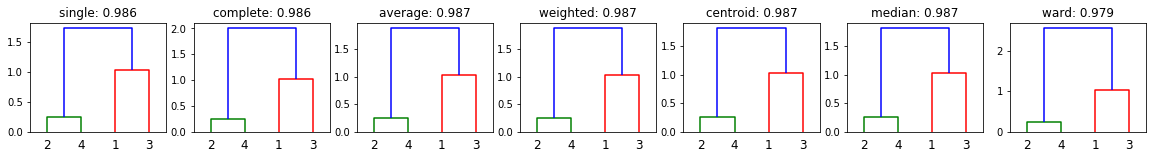

                                                              Text RhymeZone
PoemId           StanzaNo LineNo                                            
gippius_neljubov 2        001     Держу я ставни, открыть не смею,  EJu     
                          002     Держусь за ставни и страх таю.    JU      
                          003     Храню, лелею, храню, жалею        EJu     
                          004     Мой луч последний — любовь мою.   JU      


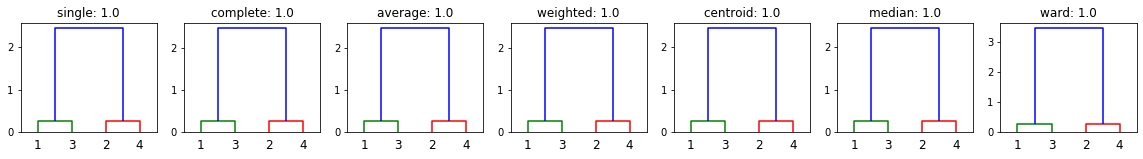

                                                              Text RhymeZone
PoemId           StanzaNo LineNo                                            
gippius_neljubov 3        001     Смеется хаос, зовет безокий:      OKiJ    
                          002     Умрешь в оковах,— порви, порви!   VI      
                          003     Ты знаешь счастье, ты одинокий,   OKiJ    
                          004     В свободе счастье — и в Нелюбви.  VI      


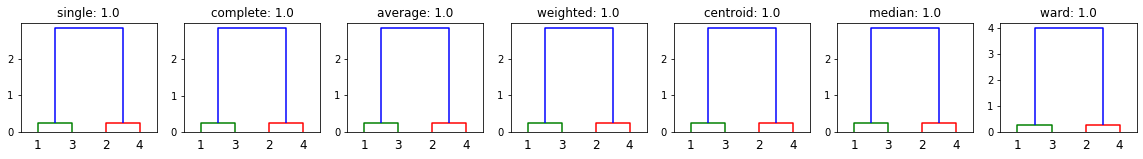

                                                         Text RhymeZone
PoemId           StanzaNo LineNo                                       
gippius_neljubov 4        001     Охладевая, творю молитву,    Itvu    
                          002     Любви молитву едва творю…    RU      
                          003     Слабеют руки, кончаю битву,  Itvu    
                          004     Слабеют руки… Я отворю!      RU      


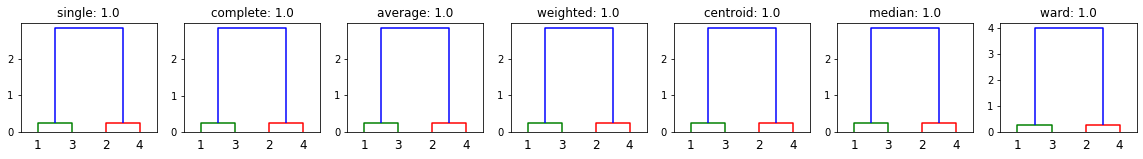

In [38]:
explore("data_samples/gippius_neljubov.xml")

## Cvetaeva “Novogodnee”

                                                                                  Text RhymeZone
PoemId                StanzaNo LineNo                                                           
cvetaeva_novogodnee_y 1        001     С Новым годом — светом — краем — кровом!         Ovam    
                               002     Первое письмо тебе на новом                      Ovam    
                               003     — Недоразумение, что злачном —                   AČnam   
                               004     (Злачном — жвачном) месте зычном, месте звучном  UČnam   
                               005     Как Эолова пустая башня.                         AšNi    
                               006     Первое письмо тебе с вчерашней,                  AšNiJ   
                               007     На которой без тебя изноюсь,                     OJuS    
                               008     Родины, теперь уже с одной из                    OJis    


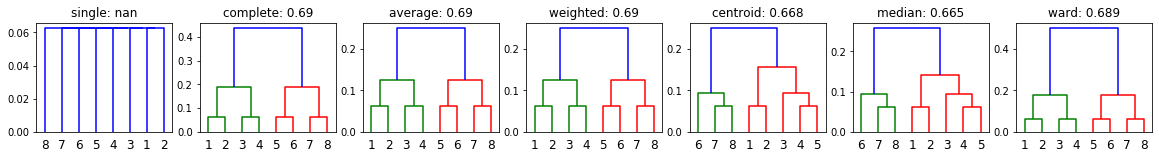

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 2        009     Звезд… Закон отхода и отбоя,             OJi     
                               010     По которому любимая любою                OJu     
                               011     И небывшею из небывалой.                 AlaJ    
                               012     Рассказать, как про твою узнала?         Ala     
                               013     Не землетрясенье, не лавина.             Ina     
                               014     Человек вошел — любой — (любимый —       ImiJ    
                               015     Ты). — Прискорбнейшее из событий.        ITiJ    
                               016     — В Новостях и в Днях. — Статью дадите?  ITi     


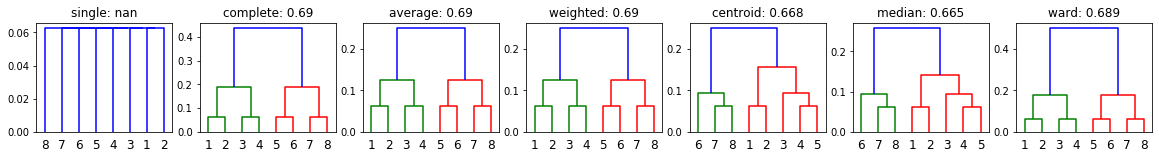

                                                                             Text RhymeZone
PoemId                StanzaNo LineNo                                                      
cvetaeva_novogodnee_y 3        017     — Где? — В горах. (Окно в еловых ветках.    Etkax   
                               018     Простыня.) — Не видите газет ведь?          EtViT   
                               019     Так статью? — Нет. — Но… — Прошу избавить.  AViT    
                               020     Вслух: трудна. Внутрь: не христопродавец.   AVits   
                               021     — В санатории. (В раю наёмном.)             Omnam   
                               022     — День? — Вчера, позавчера, не помню.       OmNu    
                               023     В Альказаре будете? — Не буду.              Udu     
                               024     Вслух: семья. Внутрь: всё, но не Иуда.      Uda     


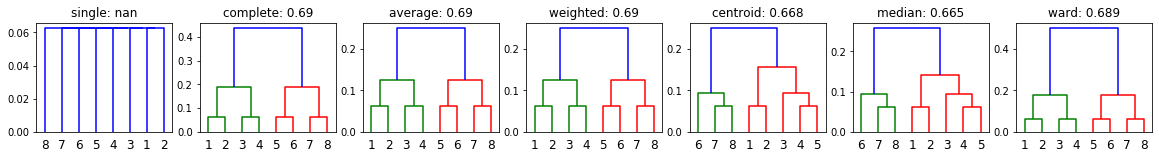

                                                                         Text RhymeZone
PoemId                StanzaNo LineNo                                                  
cvetaeva_novogodnee_y 4        025      С наступающим! (Рождался завтра!) —    Aftra   
                               026      Рассказать, что сделала, узнав про..?  Afpra   
                               027      Тсс… Оговорилась. По привычке.         IČKi    
                               028      Жизнь и смерть давно беру в кавычки,   IČKi    
                               029      Как заведомо-пустые сплёты.            Oti     
                               030      Ничего не сделала, но что-то           O-ta    
                               031      Сделалось, без тени и без эха          Exa     
                               032–033  Делающее! Теперь — как ехал?           Exal    


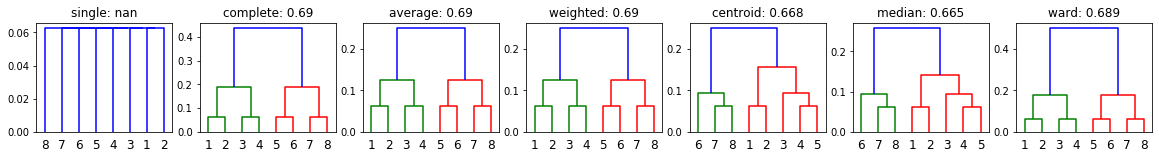

                                                                         Text RhymeZone
PoemId                StanzaNo LineNo                                                  
cvetaeva_novogodnee_y 5        034     Как рвалось и не разорвалось как —      OSkak   
                               035     Сердце? Как на рысаках орловских,       OfsKix  
                               036     От орлов, сказал, не отстающих,         UQix    
                               037     Дух захватывало — или пуще?             UQi     
                               038     Слаще? Ни высот тому, ни спусков        Uskaf   
                               039     На орлах летал заправских русских —     UsKix   
                               040     Кто. Связь кровная у нас с тем светом:  Etam    
                               041     На Руси бывал — тoт свет на этом        Etam    


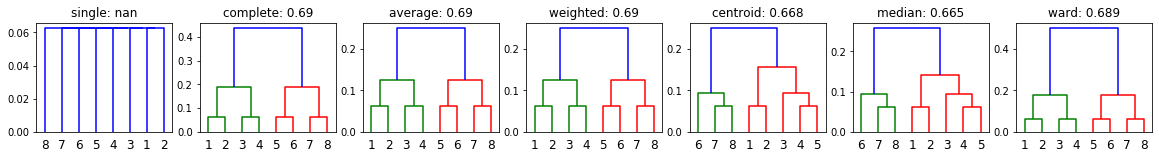

                                                                        Text RhymeZone
PoemId                StanzaNo LineNo                                                 
cvetaeva_novogodnee_y 6        042      Зрел. Налаженная перебежка!           Eška    
                               043      Жизнь и смерть произношу с усмешкой,  EškaJ   
                               044      Скрытою — своей ее коснёшься!         OšSi    
                               045      Жизнь и смерть произношу со сноской,  OskaJ   
                               046      Звездочкою (ночь, которой чаю:        AJu     
                               047      Вместо мозгового полушарья —          ARJi    
                               048–049  Звёздное!) Не позабыть бы, друг мой,  UkmaJ   
                               050      Следующего: что если буквы            Ukvi    


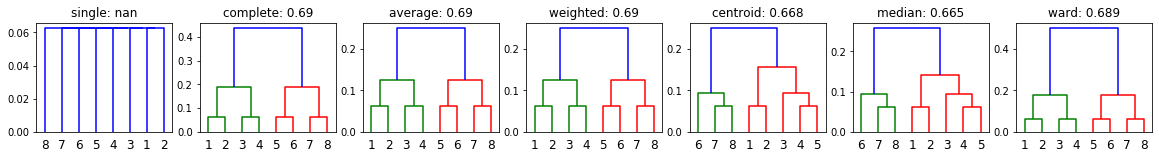

                                                                              Text RhymeZone
PoemId                StanzaNo LineNo                                                       
cvetaeva_novogodnee_y 7        051     Русские пошли взамен немецких —              EtsKix  
                               052     То не потому, что нынче, дескать,            EskaT   
                               053     Всё сойдет, что мертвый (нищий) все съест —  Est     
                               054     Не сморгнет! — а потому что тот свет,        Et      
                               055     Наш, — тринадцати, в Новодевичьем            IČJim   
                               056     Поняла: не без- а вс?-язычен.                IČin    
                               057     Вот и спрашиваю не без грусти:               USTi    
                               058     Уж не спрашиваешь, как по-русски             UsKi    


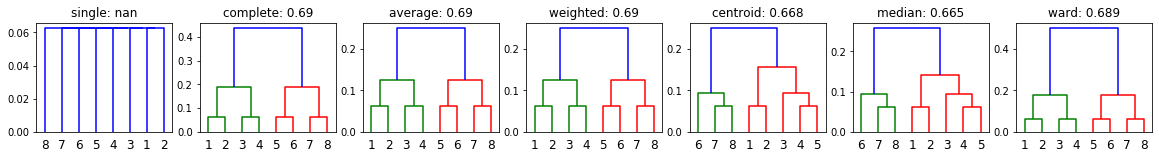

                                                                            Text RhymeZone
PoemId                StanzaNo LineNo                                                     
cvetaeva_novogodnee_y 8        059     Nest? Единственная, и все гнёзда           Ozda    
                               060     Покрывающая рифма: звёзды.                 Ozdi    
                               061     Отвлекаюсь? Но такой и вещи                EQi     
                               062     Не найдется — от тебя отвлечься.           EČSi    
                               063     Каждый помысел, любой, Du Lieber,          Ebir    
                               064     Слог в тебя ведет — о чем бы ни был        Ibil    
                               065     Толк (пусть русского родней немецкий       EtsKiJ  
                               066     Мне, всех ангельский родней!) — как места  Esta    


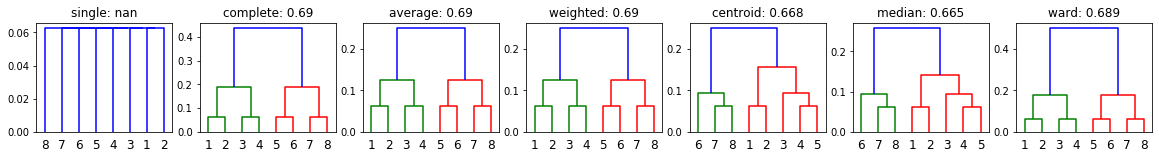

                                                                         Text RhymeZone
PoemId                StanzaNo LineNo                                                  
cvetaeva_novogodnee_y 9        067     Несть, где нет тебя, нет есть: могила.  Ila     
                               068     Всё как не было и всё как было,         Ila     
                               069     — Неужели обо мне ничуть не? —          UTNi    
                               070     Окруженье, Райнер, самочувствье?        UfstVJi 
                               071     Настоятельно, всенепременно —           Ena     
                               072     Первое видение вселенной                EnaJ    
                               073     (Подразумевается, поэта                 Eta     
                               074     В оной) и последнее — планеты,          Eti     


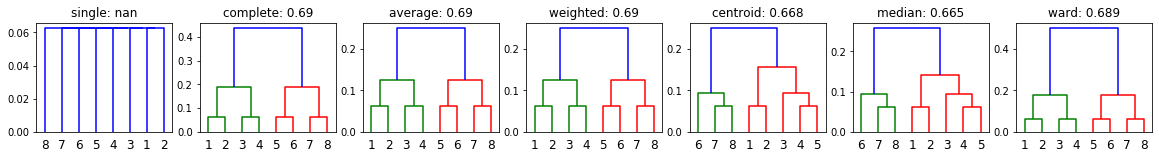

                                                                      Text RhymeZone
PoemId                StanzaNo LineNo                                               
cvetaeva_novogodnee_y 10       075     Раз только тебе и данной — в целом!  Elam    
                               076     Не поэта с прахом, духа с телом,     Elam    
                               077     (Обособить — оскорбить обоих)        OJix    
                               078     А тебя с тобой, тебя с тобою ж,      OJuš    
                               079     — Быть Зевесовым не значит лучшим —  UČšim   
                               080     Кастора — тебя с тобой — Поллуксом,  Uksam   
                               081     Мрамора — тебя с тобою, травкой,     AfkaJ   
                               082     Не разлуку и не встречу — ставку     Afku    


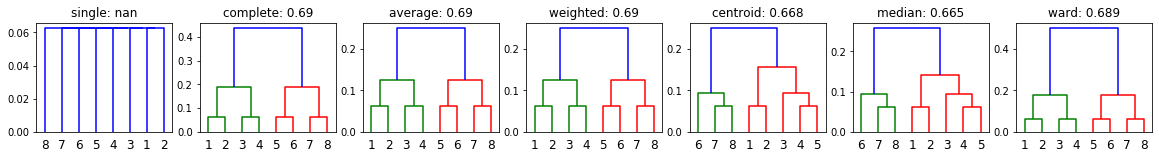

                                                                              Text RhymeZone
PoemId                StanzaNo LineNo                                                       
cvetaeva_novogodnee_y 11       083      Очную: и встречу и разлуку                  Uku     
                               084–085  Первую. На собственную руку                 Uku     
                               086      Как глядел (на след — на ней — чернильный)  ILniJ   
                               087      Со своей столько-то (сколько?) мильной      ILnaJ   
                               088      Бесконечной ибо безначальной                ALnaJ   
                               089      Высоты над уровнем хрустальным              ALnim   
                               090      Средиземного — и прочих блюдец.             UDits   
                               091      Всё как не было и всё как будет             UDit    


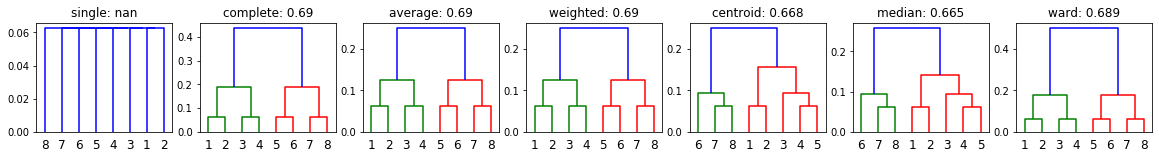

                                                                       Text RhymeZone
PoemId                StanzaNo LineNo                                                
cvetaeva_novogodnee_y 12       092     И со мною за концом предместья.       ESTJi   
                               093     Всё как не было и всё как есть уж     ESTuš   
                               094     — Что списавшемуся до недельки        ELKi    
                               095     Лишней! — и куда ж еще глядеть-то,    ET-ta   
                               096     Приоблокотясь на обод ложи,           Oži     
                               097     С этого — как не на тот, с того же —  Oži     
                               098     Как не на многострадальный этот.      Etat    
                               099     В Беллевю живу. Из гнезд и веток      Etak    


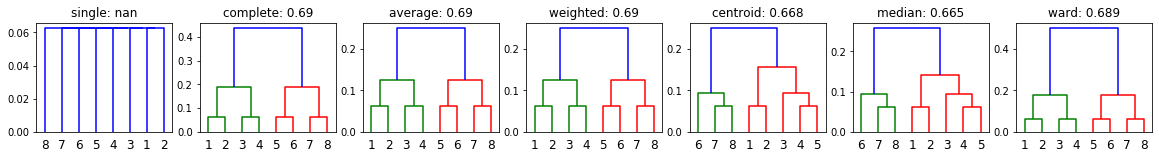

                                                                          Text RhymeZone
PoemId                StanzaNo LineNo                                                   
cvetaeva_novogodnee_y 13       100     Городок. Переглянувшись с гидом:         Idam    
                               101     Беллевю. Острог с прекрасным видом       Idam    
                               102     На Париж — чертог химеры галльской —     AlLskaJ 
                               103     На Париж — и на немножко дальше…         ALši    
                               104     Приоблокотясь на алый обод,              Obat    
                               105     Как тебе смешны (кому) «должно быть»,    ObiT    
                               106     (Мне ж) должны быть, с высоты без меры,  Eri     
                               107     Наши Беллевю и Бельведеры!               Eri     


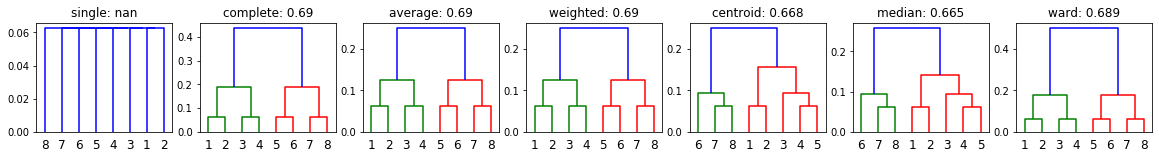

In [ ]:
explore("data_samples/cvetaeva_novogodnee_y.xml")